In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')

! pip install umap-learn
! pip install hdbscan

!/opt/bin/nvidia-smi

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from umap.umap_ import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering
from hdbscan import HDBSCAN
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Sat Feb  4 06:51:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
|

# Flowers Dataset and VGG Features

In [3]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [4]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
print(f_all)

(3670, 4096) (3670,)
[[ 9.37179863e-01 -6.90179646e-01  2.39014626e-03 ... -3.03868651e+00
   9.83097777e-02  2.75655675e+00]
 [-3.05065942e+00 -1.11963034e+00 -3.42605853e+00 ... -2.37021399e+00
   5.16861820e+00  5.92042506e-01]
 [-3.94888520e+00 -1.59134531e+00 -8.90769243e-01 ... -4.52328348e+00
   6.88483834e-01 -6.92153096e-01]
 ...
 [-4.60707092e+00  1.30045533e-01 -2.01541662e-01 ... -1.02056351e+01
  -3.39099216e+00 -8.75624120e-01]
 [ 5.97953975e-01 -2.51507854e+00 -8.55913281e-01 ... -2.00605464e+00
   2.53073931e-01 -1.84785652e+00]
 [-4.50047940e-01 -1.24751532e+00 -8.76499414e-02 ...  2.90156150e+00
  -1.14276457e+00  3.81629682e+00]]


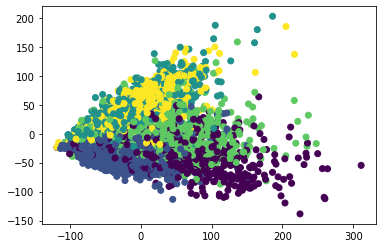

In [5]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# Q23 T-SNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


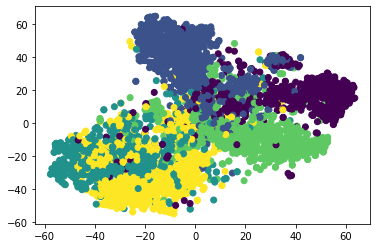

In [6]:
tsne_model = TSNE(n_components=2, random_state=42)
f_tsne = tsne_model.fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)
plt.savefig('T-SNE.png')

# Q24 Grid Search

# Autoencoder

In [7]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        #X = torch.tensor(X, dtype=torch.float32)
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        # set the random seed
        torch.manual_seed(42)       
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        #X = torch.tensor(X, dtype=torch.float32)
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


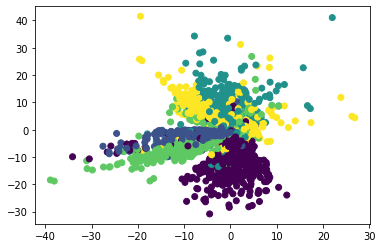

In [8]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [9]:
f_svd = TruncatedSVD(50, random_state=0).fit_transform(f_all)
f_umap = UMAP(n_components=50, metric='cosine', random_state=0).fit_transform(f_all)
f_aencode = Autoencoder(50).fit_transform(f_all)
k_means = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30)
agglomerative_cluster = AgglomerativeClustering(n_clusters=5)

100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


In [10]:
k_means_predict_none = k_means.fit(f_all).labels_
score = adjusted_rand_score(y_all, k_means_predict_none)
print('Score for None + K-means:', score)

k_means_predict_svd = k_means.fit(f_svd).labels_
score = adjusted_rand_score(y_all, k_means_predict_svd)
print('Score for SVD + K-means:', score)

k_means_predict_umap = k_means.fit(f_umap).labels_
score = adjusted_rand_score(y_all, k_means_predict_umap)
print('Score for UMAP + K-means:', score)

k_means_predict_aencode = k_means.fit(f_aencode).labels_
score = adjusted_rand_score(y_all, k_means_predict_aencode)
print('Score for Autoencoder + K-means:', score)

agglomerative_cluster_predict_none = agglomerative_cluster.fit(f_all).labels_
score = adjusted_rand_score(y_all, agglomerative_cluster_predict_none)
print('Score for None + Agglomerative Cluster:', score)

agglomerative_cluster_predict_svd = agglomerative_cluster.fit(f_svd).labels_
score = adjusted_rand_score(y_all, agglomerative_cluster_predict_svd)
print('Score for SVD + Agglomerative Cluster:', score)

agglomerative_cluster_predict_umap = agglomerative_cluster.fit(f_umap).labels_
score = adjusted_rand_score(y_all, agglomerative_cluster_predict_umap)
print('Score for UMAP + Agglomerative Cluster:', score)

agglomerative_cluster_predict_aencode = agglomerative_cluster.fit(f_aencode).labels_
score = adjusted_rand_score(y_all, agglomerative_cluster_predict_aencode)
print('Score for Autoencoder + Agglomerative Cluster:', score)


Score for None + K-means: 0.19339433652666096
Score for SVD + K-means: 0.1908374136967877
Score for UMAP + K-means: 0.4697483288647768
Score for Autoencoder + K-means: 0.24205623908876112
Score for None + Agglomerative Cluster: 0.18855278251971858
Score for SVD + Agglomerative Cluster: 0.22870918360353068
Score for UMAP + Agglomerative Cluster: 0.4518254873866642
Score for Autoencoder + Agglomerative Cluster: 0.14310429631869945


In [11]:
min_cluster_size = [3, 5, 8]
min_samples = [10, 12, 15]
for i in min_cluster_size:
    for j in min_samples:
        hdbscan = HDBSCAN(min_cluster_size=i, min_samples=j)
        hdbscan_predict_none = hdbscan.fit(f_all).labels_
        score = adjusted_rand_score(y_all, hdbscan_predict_none)
        print('Score for None + HDBSCAN[min cluster size=',i,'min samples=',j,']=', score)

        hdbscan_predict_svd = hdbscan.fit(f_svd).labels_
        score = adjusted_rand_score(y_all, hdbscan_predict_svd)
        print('Score for SVD + HDBSCAN[min cluster size=',i,'min samples=',j,']=', score)

        hdbscan_predict_umap = hdbscan.fit(f_umap).labels_
        score = adjusted_rand_score(y_all, hdbscan_predict_umap)
        print('Score for UMAP + HDBSCAN[min cluster size=',i,'min samples=',j,']=', score)

        hdbscan_predict_aencode = hdbscan.fit(f_aencode).labels_
        score = adjusted_rand_score(y_all, hdbscan_predict_aencode)
        print('Score for Autoencoder + HDBSCAN[min cluster size=',i,'min samples=',j,']=', score)



Score for None + HDBSCAN[min cluster size= 3 min samples= 10 ]= -0.00204260564482187
Score for SVD + HDBSCAN[min cluster size= 3 min samples= 10 ]= 0.015245466262597587
Score for UMAP + HDBSCAN[min cluster size= 3 min samples= 10 ]= 0.0953565808444732
Score for Autoencoder + HDBSCAN[min cluster size= 3 min samples= 10 ]= 0.01179915962968664
Score for None + HDBSCAN[min cluster size= 3 min samples= 12 ]= 0.0
Score for SVD + HDBSCAN[min cluster size= 3 min samples= 12 ]= 0.004179216811356497
Score for UMAP + HDBSCAN[min cluster size= 3 min samples= 12 ]= 0.0953565808444732
Score for Autoencoder + HDBSCAN[min cluster size= 3 min samples= 12 ]= 0.011097323981161708
Score for None + HDBSCAN[min cluster size= 3 min samples= 15 ]= 0.0
Score for SVD + HDBSCAN[min cluster size= 3 min samples= 15 ]= 0.002549390689526901
Score for UMAP + HDBSCAN[min cluster size= 3 min samples= 15 ]= 0.0953565808444732
Score for Autoencoder + HDBSCAN[min cluster size= 3 min samples= 15 ]= 0.014861974233095989
Sco

# MLP Classifier

In [12]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')
        print(X.shape)

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        # set the random seed
        torch.manual_seed(42)       
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)      

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                optimizer.zero_grad()
                loss = criterion(self(X_),y_)
                loss.backward()
                optimizer.step()
                ##################################
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        X_test.cuda()
        num_correct = 0
        with torch.no_grad():
            predict = np.array(self(X_test).cpu())
            print('predict label:', predict)
            print(predict.shape)
            predict_labels = np.argmax(predict, 1)
            for i in range(X_test.shape[0]):
                if predict_labels[i] == y_test[i]:
                    num_correct = num_correct + 1
        print('accuracy:', num_correct / len(y_test))

        ##################################
        

In [13]:
np.random.seed(42)  
random.seed(42)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(f_all, y_all, test_size=0.2)
print('X_train.shape:', X_train_all.shape)
print('X_test.shape:', X_test_all.shape)
print('y_train.shape:', y_train_all.shape)
print('y_test.shape:', y_test_all.shape)
np.random.seed(42)  
random.seed(42)
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(f_svd, y_all, test_size=0.2)
print('X_train_svd.shape:', X_train_svd.shape)
print('X_test_svd.shape:', X_test_svd.shape)
print('y_train_svd.shape:', y_train_svd.shape)
print('y_test_svd.shape:', y_test_svd.shape)
np.random.seed(42)  
random.seed(42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(f_umap, y_all, test_size=0.2)
print('X_train_umap.shape:', X_train_umap.shape)
print('X_test_umap.shape:', X_test_umap.shape)
print('y_train_umap.shape:', y_train_umap.shape)
print('y_test_umap.shape:', y_test_umap.shape)

X_train.shape: (2936, 4096)
X_test.shape: (734, 4096)
y_train.shape: (2936,)
y_test.shape: (734,)
X_train_svd.shape: (2936, 50)
X_test_svd.shape: (734, 50)
y_train_svd.shape: (2936,)
y_test_svd.shape: (734,)
X_train_umap.shape: (2936, 50)
X_test_umap.shape: (734, 50)
y_train_umap.shape: (2936,)
y_test_umap.shape: (734,)


In [14]:
mlp_all = MLP(X_train_all.shape[1])
mlp_all.train(X_train_all, y_train_all)
torch.save(mlp_all.state_dict(), 'mlp_all_model.pth')

torch.Size([2936, 4096])


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


In [15]:
state_dict = torch.load('mlp_all_model.pth')
mlp_all = MLP(X_test_all.shape[1])
mlp_all.load_state_dict(state_dict)
mlp_all.eval(X_test_all, y_test_all)

predict label: [[-3.7279942e+01 -3.7865585e+01 -3.0994368e-06 -3.4311218e+01
  -1.2673359e+01]
 [-2.5977936e+01 -3.7300919e+01 -3.5381802e+01  0.0000000e+00
  -3.3995495e+01]
 [-2.3571150e+01 -1.4837819e+01 -2.0487211e+01 -9.6793257e-05
  -9.2467413e+00]
 ...
 [-3.8562912e+01 -2.8788122e+01 -2.9779930e+01  0.0000000e+00
  -2.4959461e+01]
 [-4.9731430e+01  0.0000000e+00 -6.9863335e+01 -6.6862663e+01
  -6.3936302e+01]
 [-3.5048897e+01 -2.4968807e+01 -3.0019701e+01  0.0000000e+00
  -2.6118406e+01]]
(734, 5)
accuracy: 0.8950953678474114


In [16]:
mlp_svd = MLP(X_train_svd.shape[1])
mlp_svd.train(X_train_svd, y_train_svd)
torch.save(mlp_svd.state_dict(), 'mlp_svd_model.pth')

torch.Size([2936, 50])


100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


In [17]:
state_dict_svd = torch.load('mlp_svd_model.pth')
mlp_svd = MLP(X_test_svd.shape[1])
mlp_svd.load_state_dict(state_dict_svd)
mlp_svd.eval(X_test_svd, y_test_svd)

predict label: [[-3.3163460e+01 -3.7330975e+01 -3.3766290e-04 -3.7348801e+01
  -7.9936409e+00]
 [-2.1002779e+01 -3.9671425e+01 -4.5871708e+01  0.0000000e+00
  -4.7522045e+01]
 [-2.0452824e+01 -1.0904802e+01 -2.4769032e+01 -8.3406456e-03
  -4.7929840e+00]
 ...
 [-3.1309814e+01 -2.8541672e+01 -3.0464193e+01  0.0000000e+00
  -2.1299332e+01]
 [-5.8516342e+01  0.0000000e+00 -6.4129562e+01 -7.5272751e+01
  -5.9419788e+01]
 [-2.8196575e+01 -1.5465232e+01 -3.2869728e+01 -2.3841855e-07
  -2.8733959e+01]]
(734, 5)
accuracy: 0.8896457765667575


In [18]:
mlp_umap = MLP(X_train_umap.shape[1])
mlp_umap.train(X_train_umap, y_train_umap)
torch.save(mlp_umap.state_dict(), 'mlp_umap_model.pth')

torch.Size([2936, 50])


100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


In [19]:
state_dict_umap = torch.load('mlp_umap_model.pth')
mlp_umap = MLP(X_test_umap.shape[1])
mlp_umap.load_state_dict(state_dict_umap)
mlp_umap.eval(X_test_umap, y_test_umap)

predict label: [[-4.7326732e+00 -5.1481485e+00 -2.4860708e-01 -5.1726975e+00
  -1.6102818e+00]
 [-2.2884865e+00 -4.3106823e+00 -4.9592361e+00 -1.3840565e-01
  -4.9073372e+00]
 [-3.6655471e+00 -2.0519228e+00 -4.5268741e+00 -2.9000121e-01
  -2.4436278e+00]
 ...
 [-3.8937120e+00 -3.3013124e+00 -2.7382789e+00 -1.8434560e-01
  -3.0690393e+00]
 [-5.8707719e+00 -4.9871807e-03 -6.3066726e+00 -8.9440203e+00
  -8.5195246e+00]
 [-1.5224320e+00 -3.3708093e-01 -4.4740219e+00 -3.7137043e+00
  -3.4364128e+00]]
(734, 5)
accuracy: 0.8460490463215259
